In [3]:
import cv2
import base64
import numpy as np
import matplotlib.pyplot as plt

## Image Preprocessing
---

In [4]:
preloaded_images = None
with open("preloaded_images.txt", "r") as file:
    preloaded_images = eval(file.read())
selected_diff_image = preloaded_images[2]

# Convert image
decoded_image = base64.b64decode(selected_diff_image.split(',')[1])
image_array = np.frombuffer(decoded_image, dtype=np.uint8)
origial = cv2.imdecode(image_array, cv2.IMREAD_COLOR)

# origial = cv2.imread("components/image_preprocessing/elefant.jpeg")
_, origial_encoded = cv2.imencode('.png', origial)
original_base64 = base64.b64encode(origial_encoded).decode('utf-8')


# Graustufenbild
gray = cv2.cvtColor(origial, cv2.COLOR_BGR2GRAY)
_, gray_encoded = cv2.imencode('.png', gray)
gray_base64 = base64.b64encode(gray_encoded).decode('utf-8')

# Rauschen eliminieren
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
_, blurred_encoded = cv2.imencode('.png', blurred)
blurred_base64 = base64.b64encode(blurred_encoded).decode('utf-8')

# Canny-Kanten-Detektor
edges = cv2.Canny(blurred, 100, 200)
_, edges_encoded = cv2.imencode('.png', edges)

# Kantenbreite (4 Pixel)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (4, 4))
dilated = cv2.dilate(edges, kernel)
_, dilated_encoded = cv2.imencode('.png', dilated)

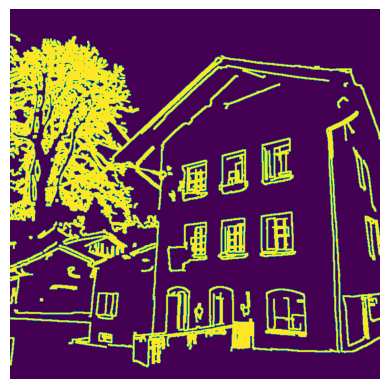

In [5]:
plt.imshow(dilated)
plt.axis('off')  # Remove the axis labels
plt.show()

In [6]:
path = "gcode.tap"


z_safe_hight = 10.0
z_working_hight = 0.5
z_depth = 3
z_feed = 500
xy_feed = 1000
spindle_speed = 24000
def generate_gcode(img, edges):
    edge_pixels = np.argwhere(edges > 0)

    scale = 0.1

    gcode = []
    gcode.append('G21\n')
    gcode.append('G90\n')
    gcode.append('G0 Z10\n')

    for pixel in edge_pixels:
        x = pixel[1] * scale
        y = (img.shape[0] - pixel[0]) * scale
        gcode.append('G0 X{:.3f} Y{:.3f}\n'.format(x,y))
        gcode.append('G1 Z-0.5 F100')

    gcode.append('G0 Z10\n')
    gcode.append('M2')


    # return gcode_data
    # Save the G-code to a file
    with open(path, "w") as f:
        f.writelines(gcode)

def get_contours(dilated, contour_minArcLength=0):
    contours, _ = cv2.findContours(dilated, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

    final_contours = []
    for c in contours:
        areaContour = cv2.arcLength(c, True)
        area_min = contour_minArcLength
        area_max = 1000000000
        if areaContour < area_min or area_max < areaContour:
            continue
        else:
            final_contours.append(c)
    return final_contours

def image_to_gcode(blurred):
    resized_image = cv2.resize(blurred, (dilated.shape[1] // 4, dilated.shape[0] // 4))

    edges = cv2.Canny(resized_image, 100, 200)
    return generate_gcode(edges, edges)

In [7]:
image_to_gcode(blurred)